# Classification problem
Here we build a simple classifier that can tell the difference between fish and cats. How would you go about writing the program that could tell this difference?

It is difficult for us to construct the function which could classify our images, but *deep learning makes the computer **do all the hard work of constructing the rules** for solving this problem

In [53]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.nn import ReLU, Softmax
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

## Data
It is not true that you always need quantities of data to train the neural network, but now we are going to train our model *from scratch*, so this case often require access to a large quantity of data

In [55]:
%run download.py

Error downloading http://www.off-n-trottin.com/images/Breyers%20and%20Kittens%20035.jpg
Error downloading http://www.arar93.dsl.pipex.com/mds975/Images/c_ronald_ginger_cat_01.jpg
Error downloading http://www.whitelightening.net/BuzzellTest/Creative/Tripp-TigerCat.jpg
Error downloading http://www.wallpaperweb.org/wallpaper/animals/thumbnail/Curious_Cat_Siberian_Tiger.jpg
Error downloading http://www1.istockphoto.com/file_thumbview_approve/2754709/2/istockphoto_2754709_white_tiger.jpg
Error downloading http://www.prestigiouspaw.com/tiger_op_450x600.jpg
Error downloading http://www.thebassethound.com/images/king1-sm.jpg
Error downloading http://www.kenairiverhideaway.com/pix1/pat3.jpg
Error downloading http://image59.webshots.com/459/3/97/24/2362397240073428963uOVsAS_ph.jpg
Error downloading http://www.portlandsalmonfishing.com/images/prices_pg/coho_salmon_sm.jpg
Error downloading http://www.southlakedecoys.com/html/decfish/deccoho.jpg
Error downloading http://www.akfishermanschoice.com/i

We now have our data, but we need to get it into a format that PyTorch can understand.  
PyTorch has developed *standard conventions* of interacting with data (in different formats: audio, images, text):
- **Dataset** is a Python class that allows us to get at the data we are supplying to the network
- **Dataloader** is what feeds data from dataset to network (with some hyperparameters)

In [56]:
# # Every dataset satisfies this abstract class

# class Dataset:
#   def __getitem__(self, index):
#     take an image, transform it and retrieve in special format
#     return (label, tensor)
#   def __len__(self):
#     return size of dataset

`torchvision` allows us to specify list of transforms that will be applied to an image before it gets into the network

In [57]:
transformations = transforms.Compose([
    
    # it is standard size which let GPU work faster
    transforms.Resize((64, 64)),
    
    # the default transform
    transforms.ToTensor(),
    
    # normalization is important to prevent
    # the values from getting too large
    # (exploding gradient problem)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# this values for mean and std are statistics from ImageNet
# (often use for other datasets)


# little function that check our image
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

Instead of `Datasets` we can use `ImageFolder` that providing our images are in a structure where each directory is a label

In [58]:
train_root = './train/'
train_dataset = ImageFolder(root=train_root,
                            transform=transformations,
                            is_valid_file=check_image)

val_root = './val/'
val_dataset = ImageFolder(root=val_root,
                          transform=transformations,
                          is_valid_file=check_image)

test_root = './test/'
test_dataset = ImageFolder(root=test_root,
                           transform=transformations,
                           is_valid_file=check_image)

We split our data into 3 parts:
- *training*: to update our model's parameters  
- *validation*: to evalute how the model is generalizing to the problem domain; not used for updating  
- *test*: final dataset that provides a final evaluation of the model's perfomance after training is complete

Now we can build our Dataloaders

In [80]:
BATCH = 8

train_data = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=BATCH,
                                        shuffle=True)
val_data = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=BATCH,
                                        shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=BATCH,
                                        shuffle=True)

`batch_size` tells us *how many images will go through the network before we train and update it*. In practice: smaller batches (*mini-batches*) require less memory than having to store all the information about every image in the dataset, and smaller batch ends up making training faster as we are updating our network more quickly

## Simple network
We are going to create a simple model:  
- input layer: will work with input images  
- hidden layer: fully-connected layer
- output layer: will be consist of 2 neurons, because we work with binary classification problem

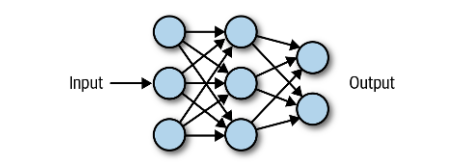
As an input passes through the network, PyTorch can simply do a *matrix multiplication of the weights and biases of that layer onto the input*. Before feeding it into the next layer, that result goes into an **activation function**, which is simply a way of *inserting nonlinearity into our system*

In [87]:
# we ingerit from a class called torch.nn.Module
# and fill the `__init__` and `forward` methods
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=64*64*3,
                                   out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84,
                                   out_features=50)
        self.fc3 = torch.nn.Linear(in_features=50,
                                   out_features=2)
    def forward(self, x):
        # we neet to convert 3D tensor to 1D because of fully connected layers
        x = x.reshape(-1, 64*64*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = Softmax(self.fc3(x))
        # we use cross entropy (see below)
        x = self.fc3(x)
        return x

    
model = SimpleNet()

We do any setup required in `init()` (calling our superclass constructor and add 3 fully connected layers). The `forward` method describes how data flows through the network in both training and making predictions (*inference*).

The number of neurons is something from art. But by reducing the size of the output with respect to the input, *we force that part of the network to learn a representation of the original input with fewer resources*, which means that *it extracts some features of the images that are important*

In [88]:
loss_fn = torch.nn.CrossEntropyLoss()

We need some way of allowing PyTorch to quantify not just whether a prediction is right or wrong, but just how wrong or right it is. This is handled by a **loss function**. PyTorch has a comprehensive collection of them (plus you can create your custom), but we are going to use `CrossEntropyLoss`, which incorporates `Softmax()` as a part of it's function

In [89]:
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Training a networks involves:  
- passing data through the network  
- using loss function to determine the difference between the prediction and the actual label  
- using loss to update weights of model in attempt to make loss value as small as possible  

To perform the last step we use `optimizer`. `learning rate` is the size of our hops in gradient descent method.

## training
Training loop combines everything we have used.

- We take a batch from our training set on *every iteration* (by our `DataLoader`)  
- give an output from model  
- compute the loss function  
- compute the gradients (using `backward` method)  
- update our weight using `step()`  
- `zero_grad()` function used because we want to look at *only the gradients of the current batch*, not at accumulated gradient. We reset `params.grad` to zero after each operation

In [90]:
# making it work in GPU if it is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device) # copy model to the GPU
model

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [91]:
def train_cycle(model,
                optimizer,
                loss_function,
                train_loader,
                val_loader,
                number_of_epoches=15,
                device='cpu'):
    
    for epoch in range(number_of_epoches):
            training_loss = 0.0
            valid_loss = 0.0
            
            model.train()
            for batch in train_loader:
                # reset grad to zero
                optimizer.zero_grad()
                
                # got the data
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # forward pass
                output = model(inputs)
                
                # calculate the loss
                loss = loss_function(output, targets)
        
                # calculate the gradients
                loss.backward()
            
                # update our weights
                optimizer.step()
                
                training_loss += loss.data.item() * inputs.size(0)
            training_loss /= len(train_loader.dataset)
            
            # to evaluation mode
            model.eval()
            number_of_correct = 0
            number_of_examples = 0
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                loss = loss_function(output, targets)
                valid_loss += loss.data.item() * inputs.size(0)
                # dim=1 in softmax because dim=0 respond to batch size
                correct_mask = torch.eq(torch.max(F.softmax(output, dim=1),
                                                  dim=1)[1], targets)
                number_of_correct += torch.sum(correct_mask).item()
                number_of_examples += correct_mask.shape[0]
            valid_loss /= len(val_loader.dataset)
            accuracy = number_of_correct / number_of_examples
            
            print('Epoch №{}:\n -- Training loss = {:.5f}\n -- Validation loss = {:.5f}\n -- Accuracy = {:.5f}'.format(epoch+1, training_loss, valid_loss, accuracy))                

We can kick off training our model

In [92]:
train_cycle(model=model,
           loss_function=loss_fn,
           optimizer=optimizer,
           train_loader=train_data,
           val_loader=val_data)

Epoch №1:
 -- Training loss = 1.88753
 -- Validation loss = 0.59725
 -- Accuracy = 0.90625
Epoch №2:
 -- Training loss = 0.67062
 -- Validation loss = 0.64339
 -- Accuracy = 0.90625
Epoch №3:
 -- Training loss = 0.72579
 -- Validation loss = 0.67120
 -- Accuracy = 0.31250
Epoch №4:
 -- Training loss = 0.71194
 -- Validation loss = 0.64674
 -- Accuracy = 0.90625
Epoch №5:
 -- Training loss = 0.72029
 -- Validation loss = 0.59852
 -- Accuracy = 0.89583
Epoch №6:
 -- Training loss = 0.69028
 -- Validation loss = 0.78216
 -- Accuracy = 0.09375
Epoch №7:
 -- Training loss = 0.70635
 -- Validation loss = 0.63238
 -- Accuracy = 0.90625
Epoch №8:
 -- Training loss = 0.67824
 -- Validation loss = 0.63520
 -- Accuracy = 0.90625
Epoch №9:
 -- Training loss = 0.76199
 -- Validation loss = 0.64249
 -- Accuracy = 0.90625
Epoch №10:
 -- Training loss = 0.69256
 -- Validation loss = 0.63695
 -- Accuracy = 0.90625
Epoch №11:
 -- Training loss = 0.69284
 -- Validation loss = 0.66060
 -- Accuracy = 0.906

After training we can evaluate our model with `test` set. But before it, let look *how we can use our model to generate a prediction for a single image*

In [99]:
def make_prediction(model, img_path):
    labels = ['cat', 'fish']
    
    img = Image.open(img_path)
    display(img)
    # reuse the transformation pipeline we made earlier
    img = transformations(img)
    img = img.to(device)
    # our network uses batches, so we should add a new dimension at the front
    img = img.unsqueeze(0)
    
    model.eval()
    prediction = F.softmax(model(img), dim=1)
    prediction = labels[prediction.argmax()]
    # argmax return the index of the highest value of the tensor,
    # which
    print(f'It is <{prediction}>')

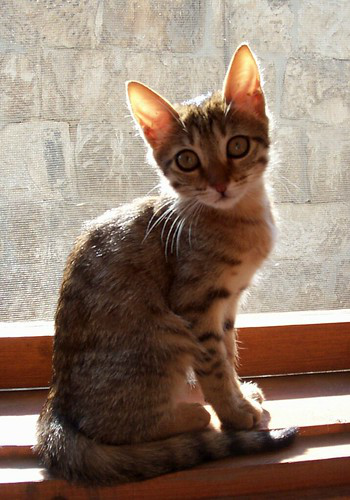

It is <cat>


In [100]:
make_prediction(model, './val/cat/54453125_ac74c8ba1d.jpg')

To make a prediction we should:  
1) passing our batch (with len=1 in this case) into the model  
2) find the class with higher probability  
3) get the index of this class and print it

In [124]:
def test_accuracy(model, test_loader):
    model.eval()
    num_correct = 0
    num_examples = len(test_loader.dataset)
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        
        correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
        num_correct += torch.sum(correct).item()
        #print('targets=', targets)
        #print('outputs=', torch.max(F.softmax(output, dim=1), dim=1)[1])
    print('Accuracy on test: {:.3f}'.format(num_correct / num_examples))

In [125]:
test_accuracy(model, test_data)

Accuracy on test: 0.572


If we are happy with the perfomance of our model (not this case but ok), we can *save the current state of a model*. By default it converted in Python's `pickle` format

In [130]:
torch.save(model, "./simplenet") 

In [132]:
# load our model
reload_model = torch.load('./simplenet')
reload_model

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

`torch.save` function stores both the parameters and the structure of the model. More common to save a model's `state_dict`. It is Python's dictionary which contains the maps of each layer's parameter in the model

In [133]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0631, -0.0341, -0.0694,  ..., -0.1556, -0.1677, -0.1699],
                      [ 0.0926,  0.0741,  0.0357,  ...,  0.1259,  0.1071,  0.1154],
                      [-0.0827, -0.0532, -0.0592,  ..., -0.0250, -0.0463, -0.0430],
                      ...,
                      [ 0.0274,  0.0186,  0.0193,  ...,  0.0751,  0.0893,  0.0863],
                      [ 0.0347,  0.0146,  0.0149,  ..., -0.0736, -0.1085, -0.0893],
                      [ 0.0044,  0.0076, -0.0019,  ...,  0.0232,  0.0119,  0.0095]])),
             ('fc1.bias',
              tensor([ 4.0669e-02, -2.2724e-01, -3.1300e-02, -7.1482e-02, -2.6241e-02,
                      -6.0888e-02, -2.1712e-01, -1.5416e-01, -1.7784e-01, -5.5111e-03,
                      -8.8924e-02, -7.9390e-02, -5.9737e-02, -1.2539e-01, -1.9892e-02,
                      -1.7204e-01, -1.9896e-01, -2.7298e-02, -2.4297e-02, -1.7834e-02,
                      -2.1222e-01,  6.9464e-02, -5.1213e-02, -1.

In [135]:
torch.save(model.state_dict(), './simplenet-params')

The benefit is that new model could **be changed**, but state dictionary assigns parameters to layers in the new model that exist in stored dictionary. (to reached this you should use `strict=False` in `load_state_dict()` method) 

In [136]:
new_model = SimpleNet()
new_model.load_state_dict(torch.load('./simplenet-params'))

<All keys matched successfully>